<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/memtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Oct  4 20:49:40 UTC 2022


In [2]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 1130, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 1130 (delta 134), reused 256 (delta 114), pack-reused 817
Receiving objects: 100% (1130/1130), 496.35 MiB | 20.96 MiB/s, done.
Resolving deltas: 100% (458/458), done.
Checking out files: 100% (154/154), done.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
plt.rcParams.update({'font.size': 20})
%config InlineBackend.figure_format = 'retina'
colors = ["#e41a1c", "#377eb8"]

In [4]:
tools = {"10xCRISPR": "Cell Ranger",
"10xFB": "Cell Ranger",
"cellhash": "CITE-seq-Count",
"clicktag": "CITE-seq-Count",
"multiseq": "CITE-seq-Count"}

In [5]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [6]:
import glob
import pandas as pd

def get_time(line):
    # returns milliseconds
    t = ":".join(line.split(":")[4:]).strip()
    hours, minutes, seconds = (["0", "0"] + t.split(":"))[-3:]
    hours = int(hours)
    minutes = int(minutes)
    seconds = float(seconds)
    ms = int(3600000 * hours + 60000 * minutes + 1000 * seconds)

    return ms
        
def get_mem(line):
    # returns bytes
    mem = int(line.split(':')[-1].strip())*1000
    return mem

def get_memtime(f):
    with open(f, 'r') as file:
        for idx, line in enumerate(file):
            if idx == 4:
                time = get_time(line)
            if idx == 9:
                mem = get_mem(line)
    return (mem, time)

def convert_memtime(files, step="align_count"):
    d = {}

    d[step] = {"time": [], "mem": []}

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem
    names = [f.split("/")[-3] for f in files]

    df = pd.DataFrame.from_dict({(i,j): d[i][j] 
                               for i in d.keys() 
                               for j in d[i].keys()})
    df.index = names
    return df
    

In [7]:
files = sorted(glob.glob(f'BMGP_2020/data/*/memtime/memtime_0.log'))
kb = convert_memtime(files, "align_count")

In [8]:
kb

align_count            
                 time         mem
10xCRISPR      245620  4196132000
10xFB          150700  4196132000
cellhash       213630  4196132000
clicktag        76000  4196132000
multiseq       227010  4196132000

In [9]:
files = sorted(glob.glob(f'BMGP_2020/data/*/memtime/memtime_1.log'))
ot = convert_memtime(files, "align_count")

In [10]:
ot

align_count             
                 time          mem
10xCRISPR     3798000  15237456000
10xFB          804660  14502036000
cellhash      5175000  15350040000
clicktag      3658000   6488268000
multiseq      3537020  19372888000

In [11]:
reads = {
    "10xCRISPR": 121_241_237,
    "10xFB": 39_096_673,
    "clicktag": 15_928_888,
    "cellhash": 74_219_921,
    "multiseq": 96_428_956
}

In [12]:
kb["nreads"] = kb.index.map(reads)
ot["nreads"] = ot.index.map(reads)

In [13]:
kb = kb.sort_values("nreads")
ot = ot.sort_values("nreads")

In [14]:
kb["tool"] = kb.index.map(tools)

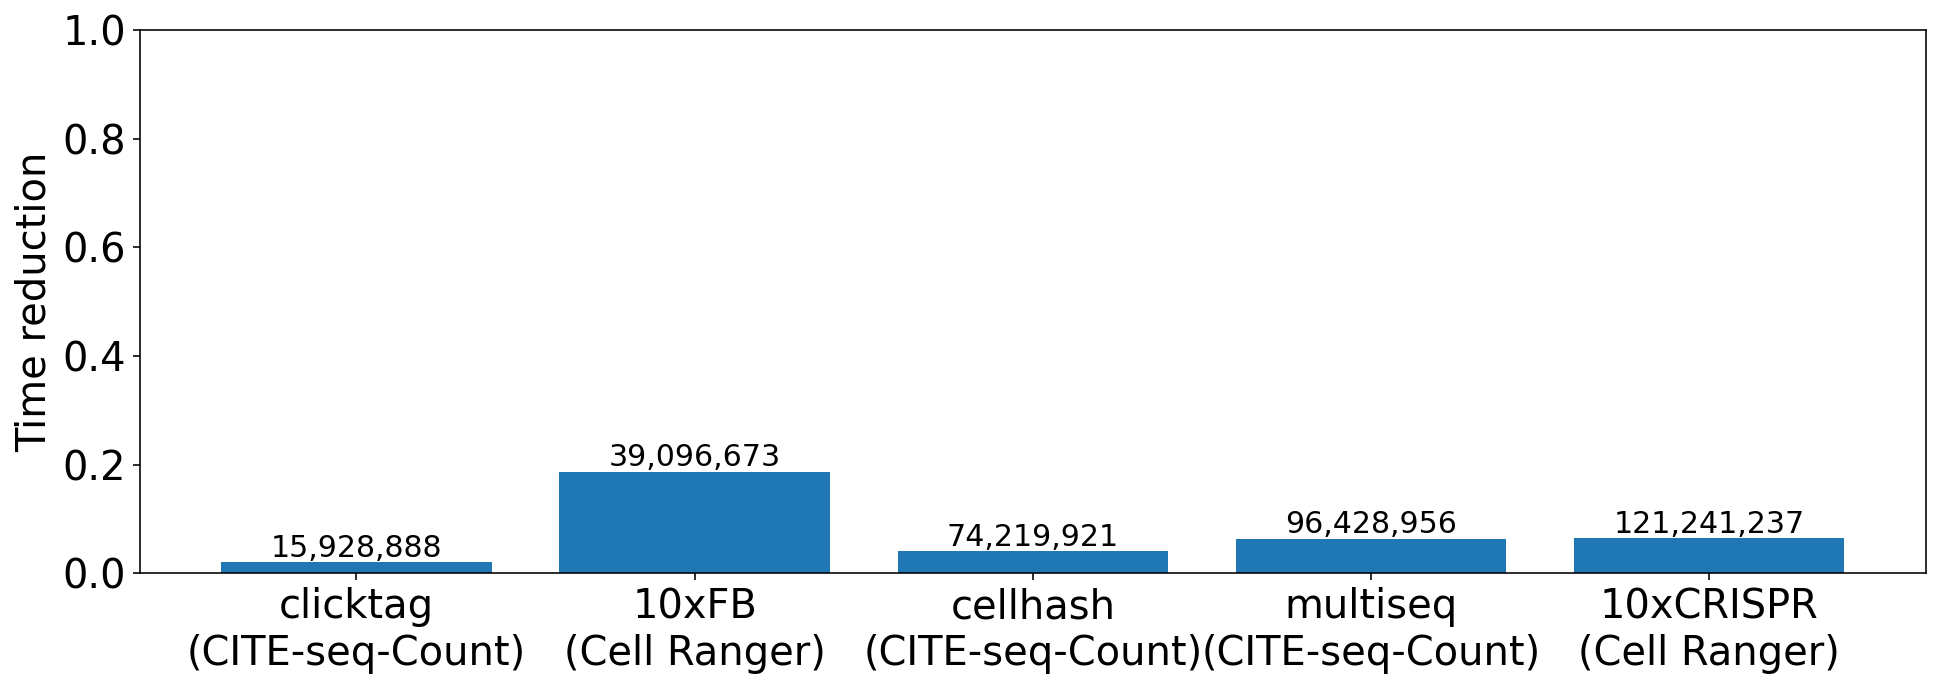

In [15]:
fig, ax = plt.subplots(figsize=(16,5))

vals = kb.align_count.time / ot.align_count.time
labels = (vals.index + "\n(" + kb.tool + ")").values
x = vals.values
ax.bar(labels, x)

nr = kb.nreads
for idx, (xx, yy) in enumerate(zip(np.arange(x.shape[0]),x)):
  ax.text(xx, yy+0.01, f"{nr[idx]:,.0f}", ha="center", rotation=0, fontsize=15)

ax.set(**{
    "ylabel": "Time reduction",
    "ylim": (0,1)
})
fig.show()

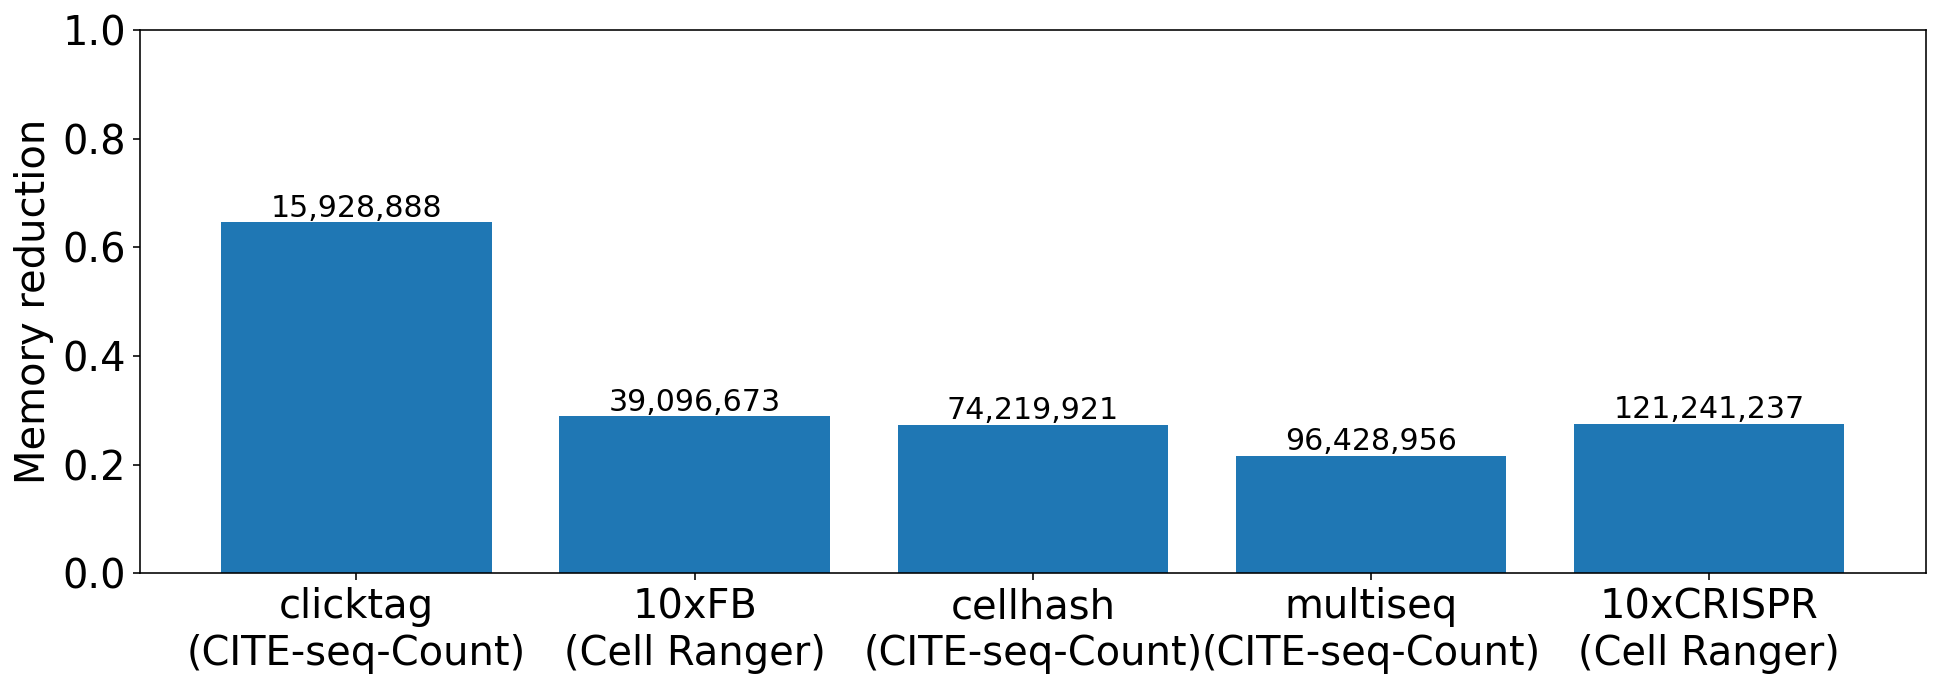

In [16]:
fig, ax = plt.subplots(figsize=(16,5))

vals = kb.align_count.mem / ot.align_count.mem
labels = (vals.index + "\n(" + kb.tool + ")").values
x = vals.values
ax.bar(labels, x)

nr = kb.nreads
for idx, (xx, yy) in enumerate(zip(np.arange(x.shape[0]),x)):
  ax.text(xx, yy+0.01, f"{nr[idx]:,.0f}", ha="center", rotation=0, fontsize=15)

ax.set(**{
    "ylabel": "Memory reduction",
    "ylim": (0,1)
})

fig.show()

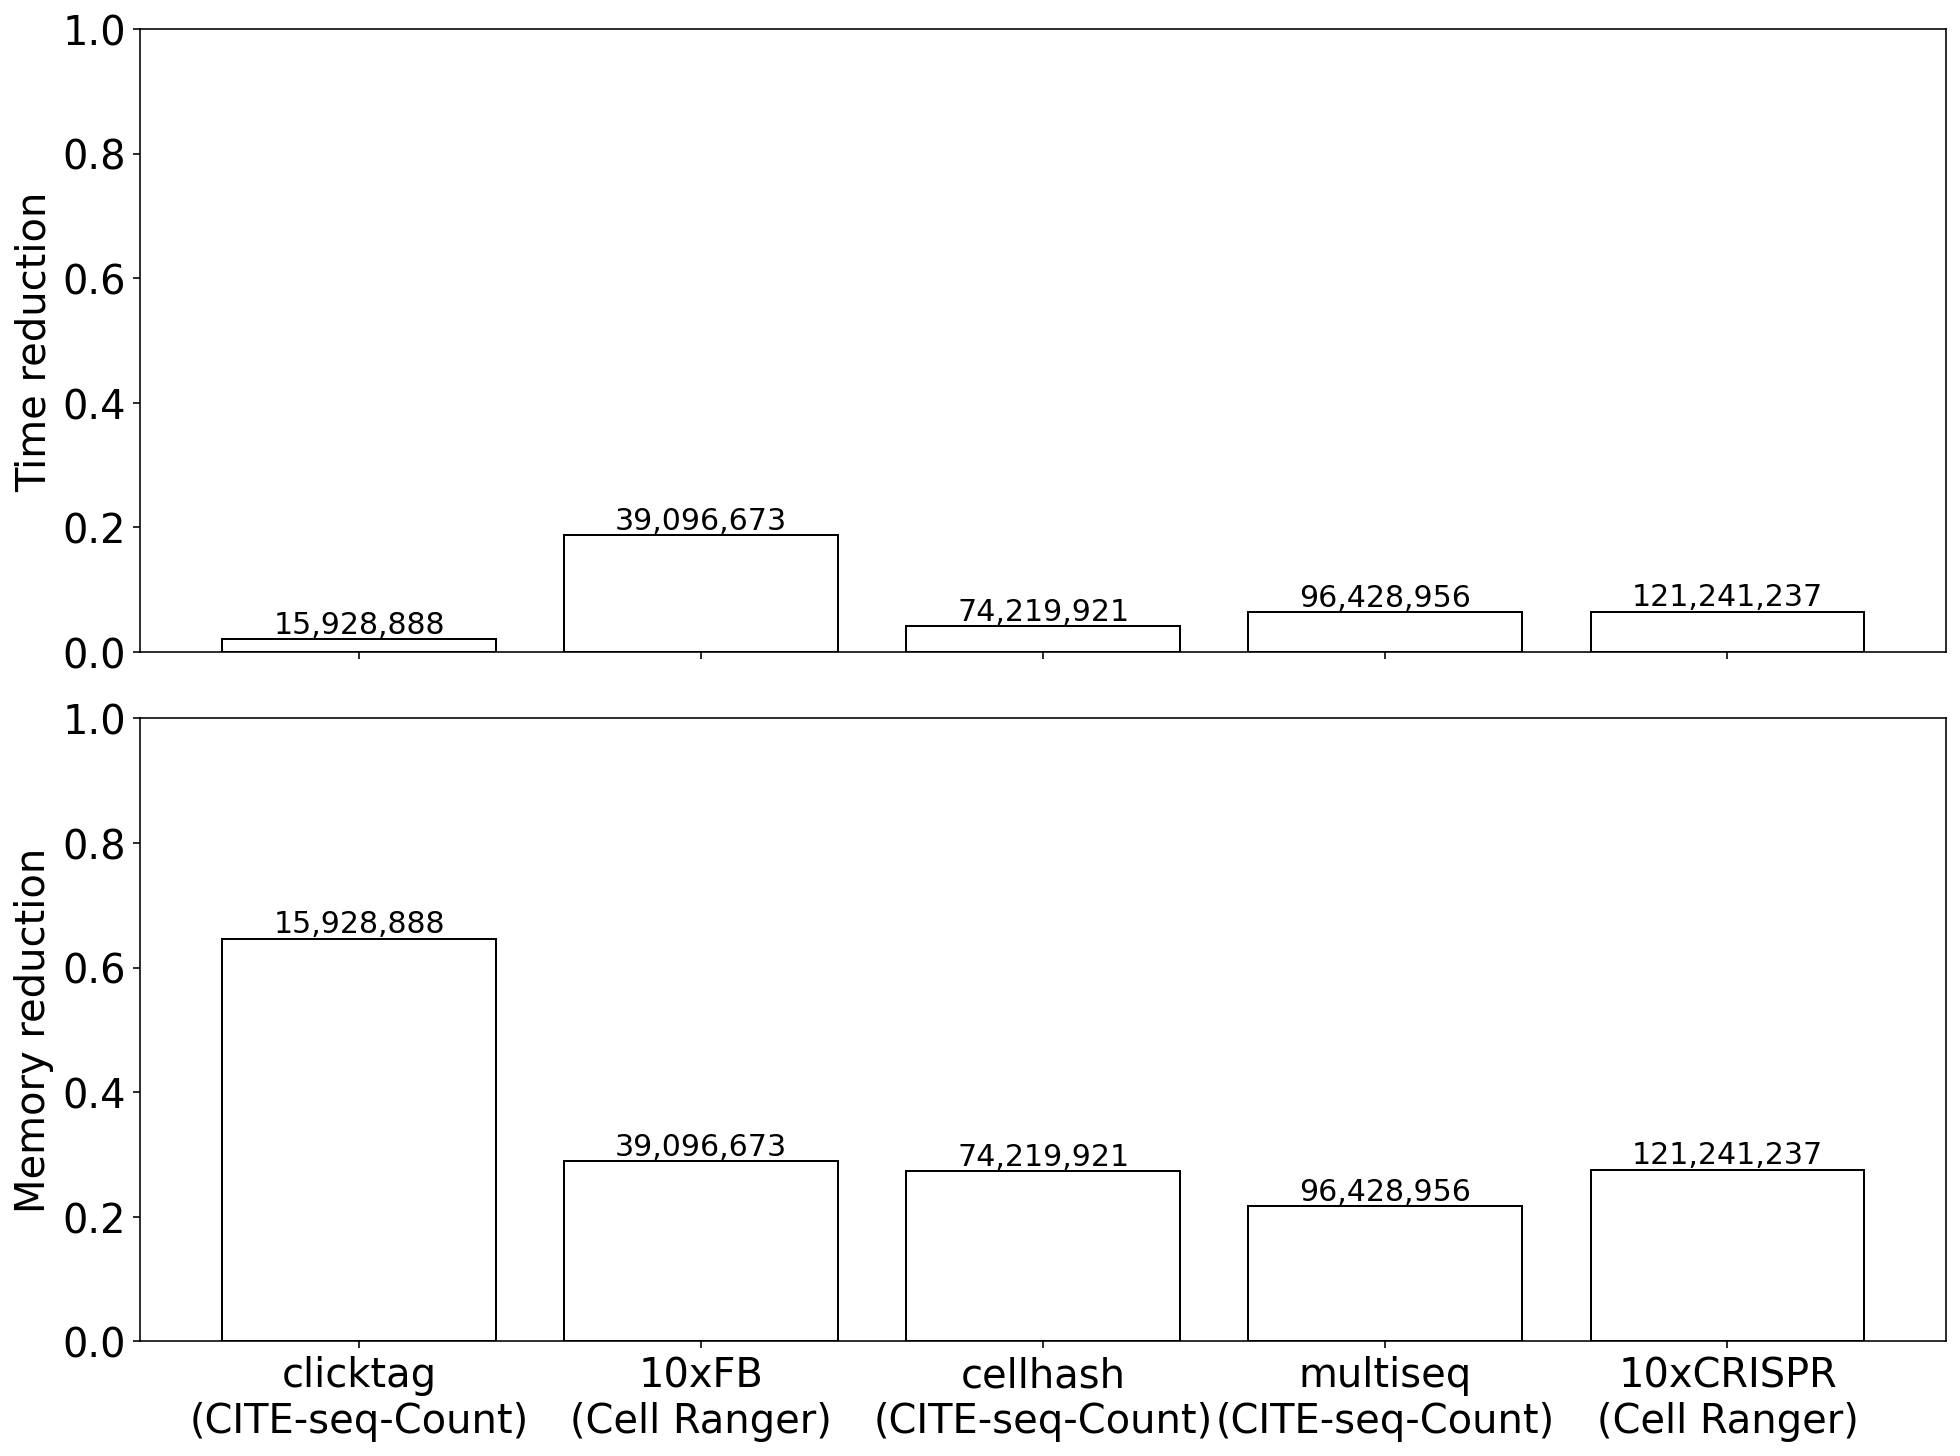

In [17]:
fig, axs = plt.subplots(figsize=(13.5,10), nrows=2, constrained_layout=True)

######### Time
ax = axs[0]
vals = kb.align_count.time / ot.align_count.time
labels = (vals.index + "\n(" + kb.tool + ")").values
x = vals.values
ax.bar(labels, x, edgecolor="k", color="white")

nr = kb.nreads
for idx, (xx, yy) in enumerate(zip(np.arange(x.shape[0]),x)):
  ax.text(xx, yy+0.01, f"{nr[idx]:,.0f}", ha="center", rotation=0, fontsize=15)

ax.set(**{
    "ylabel": "Time reduction",
    "ylim": (0,1),
    "xticklabels": []
})



######## Memory
ax = axs[1]
vals = kb.align_count.mem / ot.align_count.mem
labels = (vals.index + "\n(" + kb.tool + ")").values
x = vals.values
ax.bar(labels, x, edgecolor="k", color="white")

nr = kb.nreads
for idx, (xx, yy) in enumerate(zip(np.arange(x.shape[0]),x)):
  ax.text(xx, yy+0.01, f"{nr[idx]:,.0f}", ha="center", rotation=0, fontsize=15)

ax.set(**{
    "ylabel": "Memory reduction",
    "ylim": (0,1)
})

fig.savefig("memtime.png", bbox_inches="tight", dpi=300)
fig.show()

In [18]:
ot.align_count.time / kb.align_count.time

clicktag     48.131579
10xFB         5.339482
cellhash     24.224126
multiseq     15.580900
10xCRISPR    15.462910
Name: time, dtype: float64

In [19]:
ot.align_count.mem / kb.align_count.mem

clicktag     1.546250
10xFB        3.456049
cellhash     3.658140
multiseq     4.616844
10xCRISPR    3.631310
Name: mem, dtype: float64